In [155]:
import numpy as np
import kf_book.book_plots as book_plots
from kf_book.book_plots import figsize, set_figsize
import matplotlib.pyplot as plt

### lets try and recreate the example in the book of a dog moving between doors but instead we will change it to a cat moving between laps
# change it a bit by adding more spaces / laps
n_spots = 20
laps = 5

# cat is on a track betwen laps, randomly assign laps to spots to mix it up
cat_track = np.concatenate((np.array([0] * (n_spots - laps)), np.array([1] * laps)))
np.random.shuffle(cat_track)
cat_track

array([1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [156]:
# initially we have no idea where the cat is so set our belief to uniform
belief = np.array([1/n_spots]*n_spots)
belief

array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])

belief: [0.1        0.1        0.03333333 0.03333333 0.03333333 0.03333333
 0.1        0.03333333 0.03333333 0.1        0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.1        0.03333333
 0.03333333 0.03333333]
sum = 0.9999999999999997


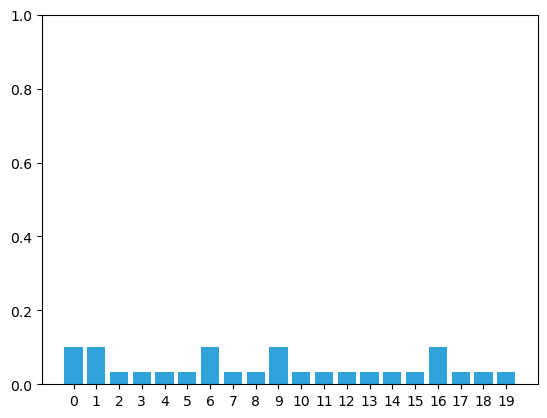

In [157]:
## this is our function for our human sensor readings, we survey our humans to see if the cat is in their lap
## but humans aren't always reliable sensors

## lets assume that they are more likely to be right than wrong
def update_belief(track, belief, z, z_prob):
    # track: the track the cat is on
    # belief: the current belief of where the cat is
    # z: the sensor reading
    # z_prob: prob sensor is correct, used to calculate scale
    
    scale = z_prob / (1 - z_prob)

    ## see book code for optimized faster numpy version, leaving as loop to be explicit
    for i, val in enumerate(track): 
        if val == z:
            # if we see the cat location = the sensor reading of "lap", increase our belief in that spot
            belief[i] *= scale
        ## this is our likelihood function, how likely is each position given our measurment
    return belief


## as shown below we increase our belief in the locations where we read a "lap"
## this is our likelihood
new_belief = update_belief(cat_track, belief, z=1, z_prob=.75)
## likelihood not a prob dist so we normalize to get one
new_belief = new_belief / sum(belief)
print('belief:', new_belief)
print('sum =', sum(new_belief))
plt.figure()
book_plots.bar_plot(new_belief)


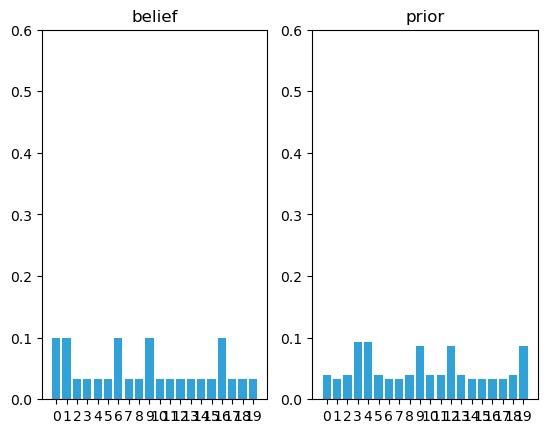

In [158]:
### lets predict movement of cat now
## skipping to convolution part

## filterpy has convolve built in predict function but do it here tp be explicit
def predict_move_convolution(pdf, offset, kernel):
    N = len(pdf)
    kN = len(kernel)
    width = int((kN - 1) / 2) ## 

    prior = np.zeros(N)
    for i in range(N):
        for k in range (kN):
            index = (i + (width-k) - offset) % N
            prior[i] += pdf[index] * kernel[k]
    return prior

prior = predict_move_convolution(new_belief, offset=3, kernel=[.1, .8, .1])
book_plots.plot_belief_vs_prior(new_belief, prior, ylim=(0,0.6)) 
# belief == likelihood of cat location given data at start
# offset is steps we predict the cat to have moved, we shift the pdf of our belief by how far we think it moved
# then we convolve with the kernel representing our uncertainty in the measurment of movement
# we then end up with a prediction of cat's location which he calls a prior since it is now 
# fed back into the update step


In [159]:
## here is code for the generalized process but don't use convienence functions from book
def update_gen(likelihood, prior):
    return (likelihood * prior) / sum(likelihood * prior)

def track_likelihood(hall, z, z_prob):
    """ compute likelihood that a measurement matches
    positions in the hallway."""
    
    try:
        scale = z_prob / (1. - z_prob)
    except ZeroDivisionError:
        scale = 1e8

    likelihood = np.ones(len(hall))
    likelihood[hall==z] *= scale
    return likelihood

def predict_move_convolution(pdf, offset, kernel):
    N = len(pdf)
    kN = len(kernel)
    width = int((kN - 1) / 2) ## 

    prior = np.zeros(N)
    for i in range(N):
        for k in range (kN):
            index = (i + (width-k) - offset) % N
            prior[i] += pdf[index] * kernel[k]
    return prior


In [160]:
import random
## full solution number of movements
move_n = 100
n_spots = 20
laps = 5
# cat is on a track betwen laps, randomly assign laps to spots to mix it up
cat_track = np.concatenate((np.array([0] * (n_spots - laps)), np.array([1] * laps)))
np.random.shuffle(cat_track)

## random movements
movements = [-1 if random.random() >.5 else 1 for i in range(move_n)]

# measurements with no noise
# zs = [cat_track[i % len(cat_track)] for i in range(move_n)]
# assume start == 0
pos = 0
zs = []
hist = []
for i, m in enumerate(movements):
    if pos == 0 and m == -1:
        pos = n_spots - 1
    elif pos == n_spots - 1 and m == 1:
        pos = 0
    else:
        pos += m
    
    hist.append(pos)
    zs.append(cat_track[pos])


In [161]:
hist[-1:] # last_spot

[18]

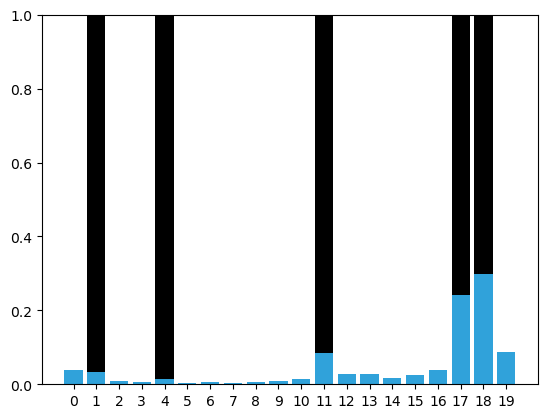

In [165]:
import kf_book.book_plots as book_plots
## loop through 100 movements
# start w/ uniform prior
posterior = np.array([1/n_spots] * n_spots)
for i, z in enumerate(zs):
    ## predict location first
    prior = predict_move_convolution(posterior, movements[i], kernel=[.1, .8, .1])

    ## get likelihood
    likelihood = track_likelihood(cat_track, z, .75)
    posterior = update_gen(likelihood, prior)

book_plots.bar_plot(cat_track, c='k')
book_plots.bar_plot(posterior, ylim=(0, 1.0))
